# Navigation

---

Congratulations for completing the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)!  In this notebook, you will learn how to control an agent in a more challenging environment, where it can learn directly from raw pixels!  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name="../UnityEnvironment/VisualBanana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The environment state is an array of raw pixels with shape `(1, 84, 84, 3)`.  *Note that this code differs from the notebook for the project, where we are grabbing **`visual_observations`** (the raw pixels) instead of **`vector_observations`**.* A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

Number of agents: 1
Number of actions: 4
States look like:


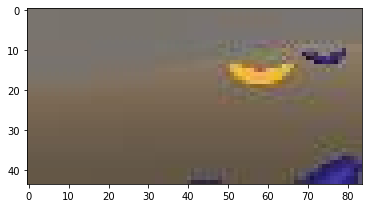

Images have shape: (84, 84, 3)
States have shape: (1, 84, 84, 3)


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state)[40:,:,:])
plt.show()
state_size = state.shape
print('Images have shape:', np.squeeze(state).shape)
print('States have shape:', state.shape)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.visual_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque, OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from dqn_agent_visual import Agent

agent = Agent(input_channels=12, action_size=4, seed=0)

Running on GPU


In [8]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):

        start_time = time.time()
        
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.visual_observations[0]            # get the current state
        state = agent.pre_process(state, reset=True)
        score = 0
        
        for t in range(max_t):
            action = int(agent.act(state, eps))
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.visual_observations[0]   # get the next state
            next_state = agent.pre_process(next_state)
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step

            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {0:4} in {1:.2f} seconds with score {2:3}\tAverage Score: {3:.2f}'.format(i_episode, time.time()-start_time, int(score), np.mean(scores_window)), end="")
        print(agent.memory.statistics(), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {0:4} in {1:.2f} seconds with score {2:3}\tAverage Score: {3:.2f}'.format(i_episode, time.time()-start_time, int(score), np.mean(scores_window)), end="")
            print(agent.memory.statistics())
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'Visual_checkpoint.pth')
            break
    return scores

scores = [0]
scores = dqn()


2470703, 459.5530128479004, 490.18988037109375, 520.8267478942871, 551.4636154174805, 582.1004829406738, 612.7373504638672, 643.3742179870605, 674.0110855102539, 704.6479530334473, 735.2848205566406, 765.921688079834, 796.5585556030273, 827.1954231262207, 857.8322906494141, 888.4691581726074, 919.1060256958008, 949.7428932189941, 980.3797607421875, 1011.0166282653809, 1041.6534957885742, 1072.2903633117676, 1102.927230834961, 1133.5640983581543, 1164.2009658813477, 1194.837833404541, 1225.4747009277344, 1256.1115684509277, 1286.748435974121, 1317.3853034973145, 1348.0221710205078, 1378.6590385437012, 1409.2959060668945, 1439.932773590088, 1470.5696411132812, 1501.2065086364746, 1531.843376159668, 1562.4802436828613, 1593.1171112060547, 1623.753978729248, 1654.3908462524414, 1685.0277137756348, 1715.6645812988281, 1746.3014488220215, 1776.9383163452148, 1807.5751838684082, 1838.2120513916016, 1868.848918914795, 1899.4857864379883, 1930.1226539611816, 1960.759521484375]

WEIGTHS 0.966221

KeyboardInterrupt: Interrupted by user

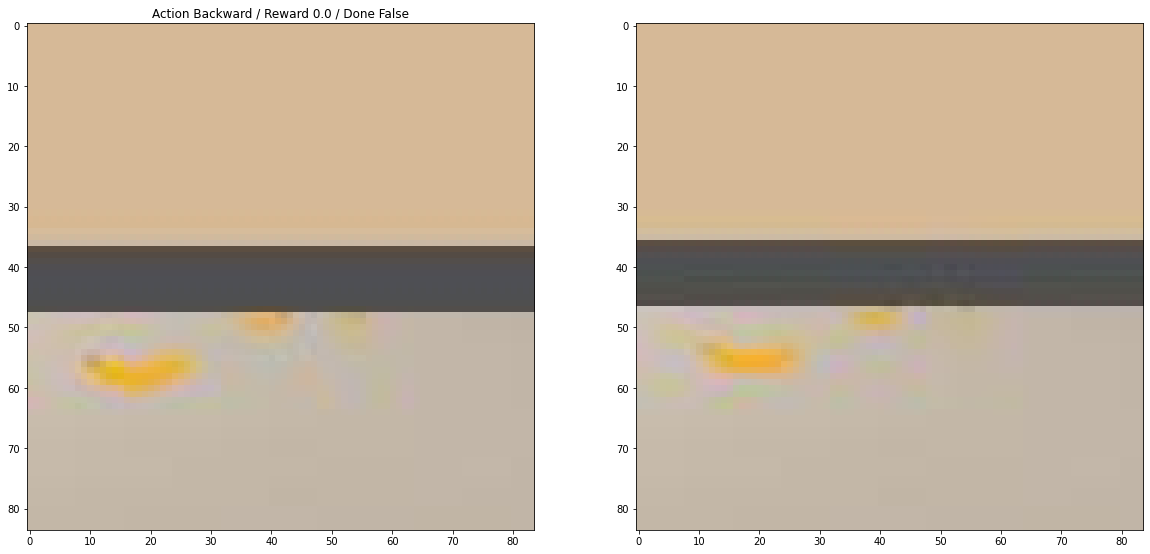

In [52]:
index = 132273 
image_state = agent.memory._sumTree._data[agent.memory._sumTree._data_index(index)].state[0,:,:,:].transpose((1, 2, 0))
image_next = agent.memory._sumTree._data[agent.memory._sumTree._data_index(index)].next_state[0,:,:,:].transpose((1, 2, 0))
action = agent.memory._sumTree._data[agent.memory._sumTree._data_index(index)].action
reward = agent.memory._sumTree._data[agent.memory._sumTree._data_index(index)].reward
done = agent.memory._sumTree._data[agent.memory._sumTree._data_index(index)].done

actions = {0: "Forward", 1: "Backward", 2: "Left", 3: "Right"}
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
plt.imshow(image_state)
plt.title("Action {} / Reward {} / Done {}".format(actions[action], reward, done))
ax2 = fig.add_subplot(122)
plt.imshow(image_next)
plt.show()

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]  # reset the environment

# Respawn an Agent and load the weights from file
agent = Agent(state_size=37, action_size=4, seed=27)
agent.qnetwork_local.load_state_dict(torch.load('Visual_checkpoint.pth'))

state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = int(agent.act(state, 0.05))           # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.visual_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

In [ ]:
env.close()